# **2. Train**
## Using the categorized and trimmed audio samples, we will train a 2D-CNN to classify out-of-sample audio recordings.

In [1]:
import numpy as np 
import librosa.display
import os 
import matplotlib.pyplot as plt 
import scipy
from glob import glob

## 1. Begin by defining functions to create mel-spectrograms from the wav files and then creating images of these spectrograms.  

In [2]:
def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
    # explicitly set sample rate = 44.1 kHz so that training images have a standard sr rather than being loaded in with their native sr
    y, sr = librosa.load(audio_file, sr = 44100) 
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    direc = os.listdir(input_path)

    for i, file in enumerate(direc):
        if file.endswith('.wav'):
            input_file = os.path.join(input_path, file)
            output_file = os.path.join(output_path, file.replace('.wav', '.png'))
            create_spectrogram(input_file, output_file)

## 2. Create spectrograms and images from the previously categorized calls.  
>#### The samples in each `clean` sub-directory are 1 second clips extracted from the [Macauly Library](https://www.macaulaylibrary.org/) that capture each distinct call.

In [3]:
# laugh
create_pngs_from_wavs('/Users/calzada/birdsongs/wood/01_data/clean/clean_laugh', '/Users/calzada/birdsongs/wood/01_data/spects/laugh')

In [4]:
# drum
create_pngs_from_wavs('/Users/calzada/birdsongs/wood/01_data/clean/clean_drum', '/Users/calzada/birdsongs/wood/01_data/spects/drum')

In [5]:
# pik
create_pngs_from_wavs('/Users/calzada/birdsongs/wood/01_data/clean/clean_pik', '/Users/calzada/birdsongs/wood/01_data/spects/pik')

In [6]:
# noise
create_pngs_from_wavs('/Users/calzada/birdsongs/wood/01_data/clean/clean_noise', '/Users/calzada/birdsongs/wood/01_data/spects/noise')

## 3. Define two new functions:
>- `load_images_from_path` loads in the previously created images as arrays, and adds these arrays to a larger `images` array.
>- `show_images` displays the images.

In [7]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        if file.endswith('.png'):
            # add image array to list
            images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
            # label array add 
            labels.append((label))
        
    return images, labels

def show_images(images):
    num_images = len(images)
    print(f'This class has {num_images} training images.')
    fig, axes = plt.subplots(1, 5, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})
    
    for i, ax in enumerate(axes.flat):
        if i <= 5:  # only plot first 5 in the dir (CHANGE)
            ax.imshow(images[i] / 255)
        else:
            ax.axis('off')  # Turn off empty subplots
    
    #plt.tight_layout()
    plt.show()

In [8]:
x = []
y = []

This class has 96 training images.


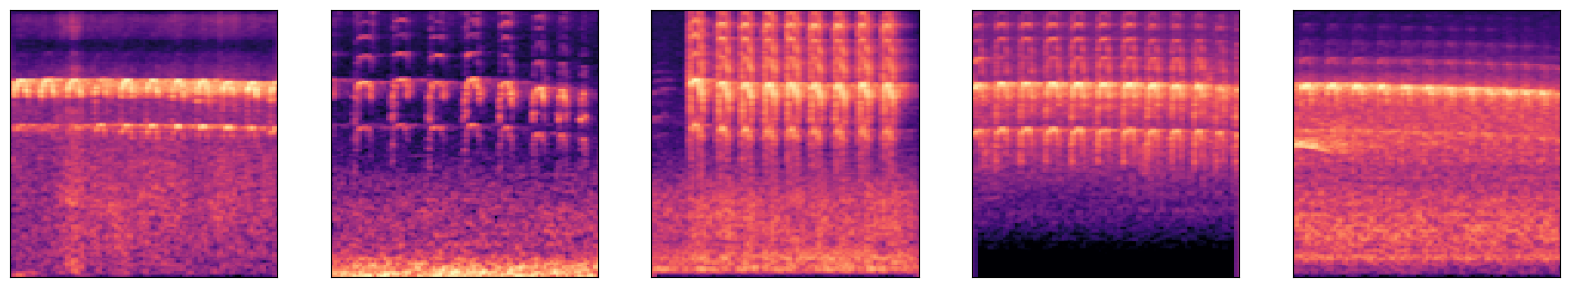

In [9]:
images, labels = load_images_from_path('/Users/calzada/birdsongs/wood/01_data/spects/laugh', 0)
show_images(images)
x += images
y += labels

This class has 28 training images.


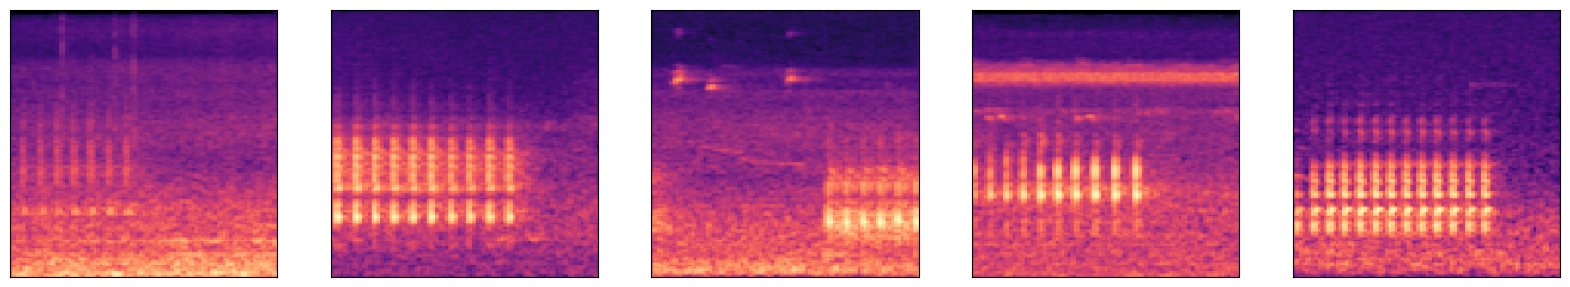

In [10]:
images, labels = load_images_from_path('/Users/calzada/birdsongs/wood/01_data/spects/drum', 1)
show_images(images)
x += images
y += labels

This class has 36 training images.


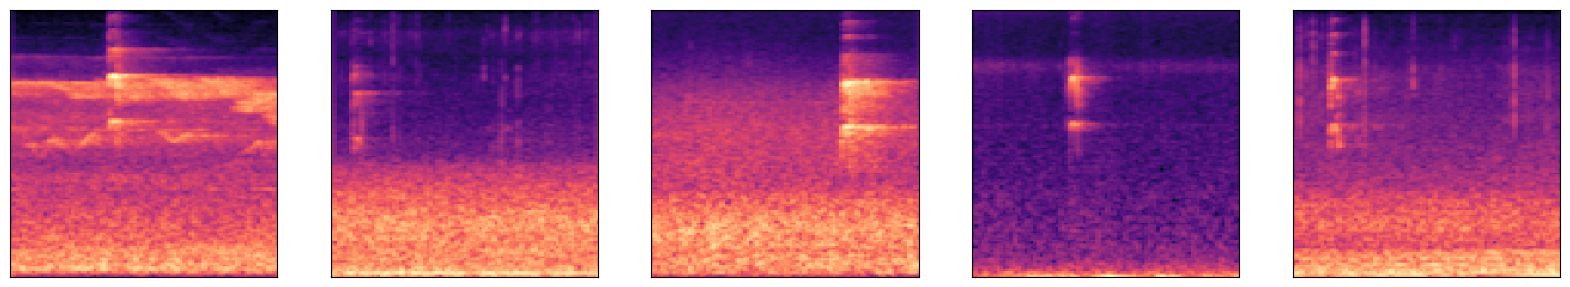

In [11]:
images, labels = load_images_from_path('/Users/calzada/birdsongs/wood/01_data/spects/pik', 2)
show_images(images)
    
x += images
y += labels

This class has 23 training images.


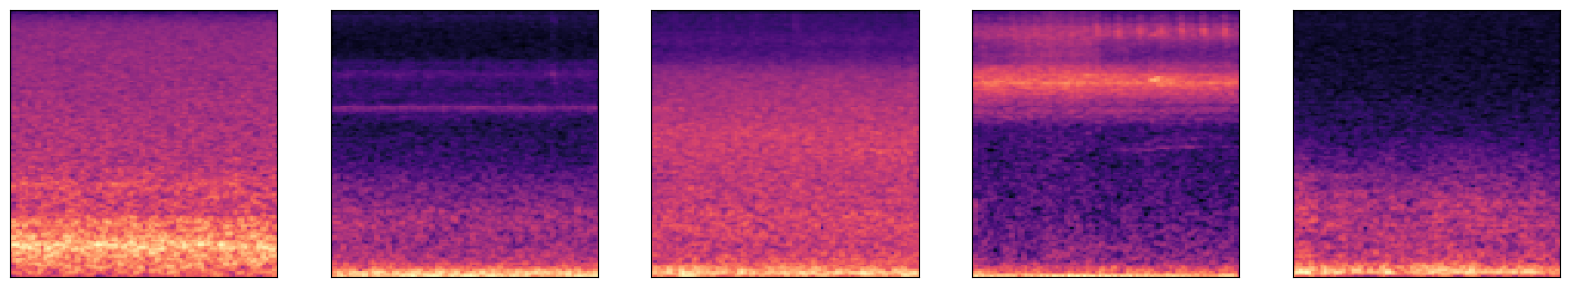

In [12]:
images, labels = load_images_from_path('/Users/calzada/birdsongs/wood/01_data/spects/noise', 3)
show_images(images)
    
x += images
y += labels

## 4. Splitting data into train and test sets.
>### Note that the y sets (the class labels) are converted from their original class label (either 0, 1, 2, 3) into binary class matrices (one-hot encoding step).

In [13]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, test_size=0.1, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train) # converting class labels (list of 0,1,2s to binary class matrix (one-hot encoding)
y_test_encoded = to_categorical(y_test)

## Define a 2D-CNN to classify these four classes.

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='softmax')) # 4 category linear classifier
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [15]:
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)

Epoch 1/10
17/17 [==============================] - 3s 135ms/step - loss: 1.3845 - accuracy: 0.5488 - val_loss: 1.5136 - val_accuracy: 0.5263
Epoch 2/10
17/17 [==============================] - 2s 131ms/step - loss: 0.9140 - accuracy: 0.6829 - val_loss: 0.9700 - val_accuracy: 0.5789
Epoch 3/10
17/17 [==============================] - 2s 132ms/step - loss: 0.7585 - accuracy: 0.6524 - val_loss: 1.0533 - val_accuracy: 0.6316
Epoch 4/10
17/17 [==============================] - 2s 131ms/step - loss: 0.6361 - accuracy: 0.7256 - val_loss: 1.2121 - val_accuracy: 0.6842
Epoch 5/10
17/17 [==============================] - 2s 131ms/step - loss: 0.5250 - accuracy: 0.7744 - val_loss: 0.8182 - val_accuracy: 0.7368
Epoch 6/10
17/17 [==============================] - 2s 132ms/step - loss: 0.6168 - accuracy: 0.7439 - val_loss: 0.7652 - val_accuracy: 0.7368
Epoch 7/10
17/17 [==============================] - 2s 133ms/step - loss: 0.4931 - accuracy: 0.8354 - val_loss: 0.8496 - val_accuracy: 0.8421
Epoch 

[]

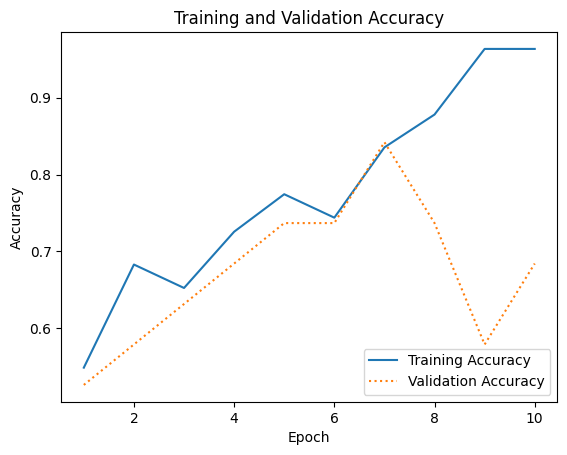

In [16]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Save model for future use. 

In [18]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
model.save('non_tl_model_with_noise.keras')

/Users/calzada/miniforge3/envs/test_audio/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
